In [2]:
%matplotlib inline
import tensorflow as tf
global tf
from IPython.display import display, HTML
import python_utils as utils
from natsort import natsorted
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import itertools
from itertools import cycle
from collections import defaultdict
from scipy import interp


import sklearn
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session
from tensorboard.plugins.pr_curve import summary as pr_summary

Using TensorFlow backend.


In [3]:
sns.set()

In [4]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
name = 'DAE'
path_to_TB = os.getcwd()+'/AUC_ROC/TB_data/'+name
call_tensorboard = keras.callbacks.TensorBoard(log_dir=path_to_TB+'logs/{}'.format(name))
filepath = path_to_TB + "/checkpoint/" + name + "-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
call_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [call_tensorboard, call_checkpoint]

In [6]:
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
plt.show()
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def draw_heat_map(report):
    plot_classification_report(report)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
       
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [8]:
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255
x_train.shape

(60000, 784)

In [9]:
m = Sequential()
m.add(Dense(784, input_shape=(784,)))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(1000))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(500))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(250))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(2, name="bottleneck"))
m.add(Dense(250))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(500))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(1000))
m.add(LeakyReLU(alpha=0.2))
m.add(Dense(784,activation='sigmoid',name='decoder'))

In [10]:
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x_train, x_train, batch_size=128, epochs=80, verbose=1, validation_data=(x_test, x_test))
encoder = Model(m.input, m.get_layer('bottleneck').output)

Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 3s 49us/step - loss: 0.0572 - val_loss: 0.0465
Epoch 2/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0439 - val_loss: 0.0421
Epoch 3/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0411 - val_loss: 0.0404
Epoch 4/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0400 - val_loss: 0.0405
Epoch 5/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0392 - val_loss: 0.0386
Epoch 6/80
60000/60000 [==============================] - 2s 36us/step - loss: 0.0386 - val_loss: 0.0390
Epoch 7/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0380 - val_loss: 0.0378
Epoch 8/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0378 - val_loss: 0.0378
Epoch 9/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0375 - val_loss: 0.0374
Epoch

Epoch 78/80
60000/60000 [==============================] - 2s 35us/step - loss: 0.0326 - val_loss: 0.0336
Epoch 79/80
60000/60000 [==============================] - 2s 36us/step - loss: 0.0326 - val_loss: 0.0336
Epoch 80/80
60000/60000 [==============================] - 2s 36us/step - loss: 0.0327 - val_loss: 0.0336


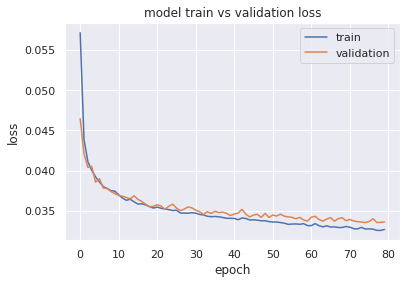

In [11]:
#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
x_test_encoded = encoder.predict(x_test)

In [13]:
x_test_encoded.shape

(10000, 2)

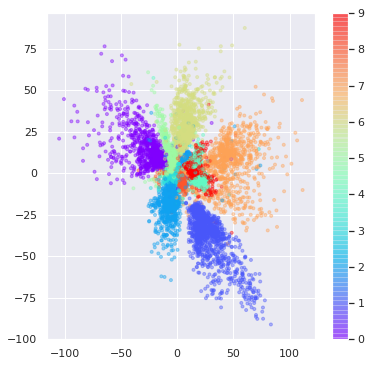

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show() 

In [43]:
train, validate, test = np.split(x_test_encoded, [int(.9*len(x_test_encoded)), int(.95*len(x_test_encoded))])

In [44]:
train, validate, test = train.reshape(54000, 2) / 255 , validate.reshape(3000, 2) / 255, test.reshape(3000,2) / 255

In [45]:
train_y, validate_y, test_y = np.split(y_train, [int(.9*len(y_train)), int(.95*len(y_train))])

In [46]:
num_classes=10

In [47]:
train_y =  keras.utils.to_categorical(train_y, num_classes)
validate_y = keras.utils.to_categorical(validate_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [21]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
__________

In [31]:
def optimize_and_fit(model, lr, epochs):
        Adam = optimizers.Adam(lr=lr)
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x=train, y=train_y, batch_size =64, 
                    validation_data = (validate, validate_y),
                    callbacks = callbacks_list,
                    epochs = epochs,
                    shuffle = True,
                    verbose = 1
                    )

In [32]:
optimize_and_fit(model, 1e-4, 1000)

Train on 54000 samples, validate on 3000 samples
Epoch 1/1000
54000/54000 [==============================] - 2s 44us/step - loss: 0.7427 - acc: 0.7454 - val_loss: 0.5024 - val_acc: 0.8323

Epoch 00001: val_acc improved from -inf to 0.83233, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/DAE/checkpoint/DAE-improvement-01-0.83.hdf5
Epoch 2/1000
54000/54000 [==============================] - 2s 41us/step - loss: 0.5653 - acc: 0.8050 - val_loss: 0.4794 - val_acc: 0.8370

Epoch 00002: val_acc improved from 0.83233 to 0.83700, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/DAE/checkpoint/DAE-improvement-02-0.84.hdf5
Epoch 3/1000
54000/54000 [==============================] - 2s 40us/step - loss: 0.5358 - acc: 0.8179 - val_loss: 0.4462 - val_acc: 0.8450

Epoch 00003: val_acc improved from 0.83700 to 0.84500, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/DAE/c

54000/54000 [==============================] - 2s 46us/step - loss: 0.4157 - acc: 0.8697 - val_loss: 0.3776 - val_acc: 0.8817

Epoch 00077: val_acc did not improve from 0.88267
Epoch 78/1000
54000/54000 [==============================] - 2s 44us/step - loss: 0.4158 - acc: 0.8714 - val_loss: 0.3874 - val_acc: 0.8777

Epoch 00078: val_acc did not improve from 0.88267
Epoch 79/1000
54000/54000 [==============================] - 2s 44us/step - loss: 0.4143 - acc: 0.8719 - val_loss: 0.3801 - val_acc: 0.8800

Epoch 00079: val_acc did not improve from 0.88267
Epoch 80/1000
54000/54000 [==============================] - 2s 43us/step - loss: 0.4135 - acc: 0.8717 - val_loss: 0.3932 - val_acc: 0.8747

Epoch 00080: val_acc did not improve from 0.88267
Epoch 81/1000
54000/54000 [==============================] - 2s 43us/step - loss: 0.4171 - acc: 0.8703 - val_loss: 0.3789 - val_acc: 0.8783

Epoch 00081: val_acc did not improve from 0.88267
Epoch 82/1000
54000/54000 [==============================] 

54000/54000 [==============================] - 3s 54us/step - loss: 0.4115 - acc: 0.8724 - val_loss: 0.3826 - val_acc: 0.8820

Epoch 00159: val_acc did not improve from 0.88633
Epoch 160/1000
54000/54000 [==============================] - 3s 54us/step - loss: 0.4082 - acc: 0.8740 - val_loss: 0.3826 - val_acc: 0.8770

Epoch 00160: val_acc did not improve from 0.88633
Epoch 161/1000
54000/54000 [==============================] - 3s 54us/step - loss: 0.4086 - acc: 0.8734 - val_loss: 0.3820 - val_acc: 0.8840

Epoch 00161: val_acc did not improve from 0.88633
Epoch 162/1000
54000/54000 [==============================] - 3s 54us/step - loss: 0.4092 - acc: 0.8731 - val_loss: 0.3830 - val_acc: 0.8800

Epoch 00162: val_acc did not improve from 0.88633
Epoch 163/1000
54000/54000 [==============================] - 3s 54us/step - loss: 0.4107 - acc: 0.8728 - val_loss: 0.3863 - val_acc: 0.8817

Epoch 00163: val_acc did not improve from 0.88633
Epoch 164/1000
54000/54000 [===========================

KeyboardInterrupt: 

In [33]:
predictions = model.predict(test, batch_size=128, verbose=1)

3000/3000 [==============================] - 0s 23us/step


Confusion matrix, without normalization
[[289   0   0   0   2   2   4   0   0   0]
 [  0 317   0   1   0   3   2   2   0   0]
 [  1   1 301   1   0   1   0   1   3   0]
 [  0   0   3 282   0   9   0   1  18   1]
 [  1   3   0   0 252   0   2   1   0  31]
 [  0   1   1  15   0 235   3   0   7   0]
 [  1   0   0   0   0   2 285   0   0   0]
 [  0   1   1   0   2   0   0 319   0   9]
 [  3   1   1  15   0  23   0   1 247   6]
 [  1   0   0   3  42   2   0   5   2 231]]


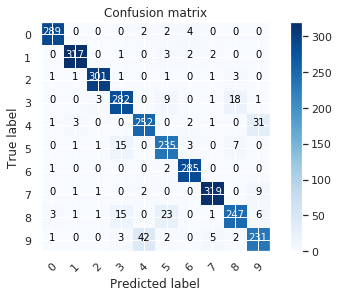

In [36]:
prediction_label, true_label = predictions_to_label_array(predictions), predictions_to_label_array(test_y)
cm = confusion_matrix(true_label, prediction_label)
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

In [37]:
report = classification_report(true_label, prediction_label, target_names=cm_plot_labels)

In [38]:
report_df = pd.DataFrame(report2dict(report)).T
report_df

,f1-score,precision,recall,support
0,0.97,0.98,0.97,297.0
1,0.98,0.98,0.98,325.0
2,0.98,0.98,0.97,309.0
3,0.89,0.89,0.90,314.0
4,0.86,0.85,0.87,290.0
5,0.87,0.85,0.90,262.0
6,0.98,0.96,0.99,288.0
7,0.96,0.97,0.96,332.0
8,0.86,0.89,0.83,297.0
9,0.82,0.83,0.81,286.0


[0.98, 0.97, 0.97]
[0.98, 0.98, 0.98]
[0.98, 0.97, 0.98]
[0.89, 0.9, 0.89]
[0.85, 0.87, 0.86]
[0.85, 0.9, 0.87]
[0.96, 0.99, 0.98]
[0.97, 0.96, 0.96]
[0.89, 0.83, 0.86]
[0.83, 0.81, 0.82]
plotMat: [[0.98, 0.97, 0.97], [0.98, 0.98, 0.98], [0.98, 0.97, 0.98], [0.89, 0.9, 0.89], [0.85, 0.87, 0.86], [0.85, 0.9, 0.87], [0.96, 0.99, 0.98], [0.97, 0.96, 0.96], [0.89, 0.83, 0.86], [0.83, 0.81, 0.82]]
support: [297, 325, 309, 314, 290, 262, 288, 332, 297, 286]


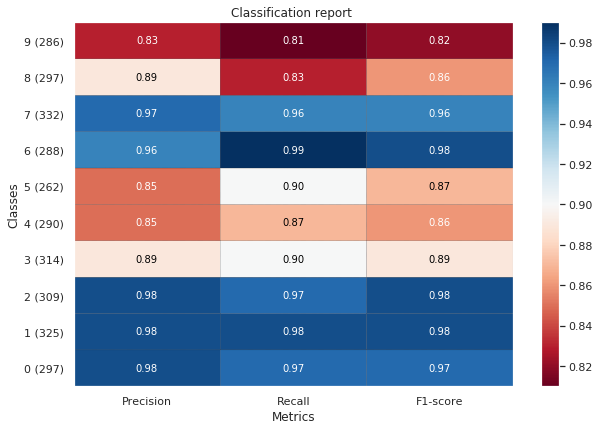

In [39]:
draw_heat_map(report)

In [50]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

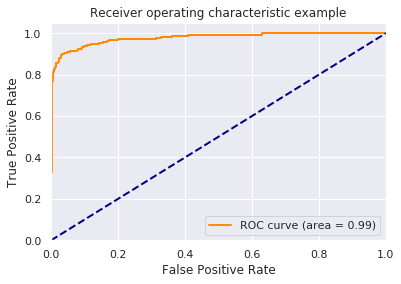

In [51]:
plt.figure()
lw = 2
plt.plot(fpr[8], tpr[8], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

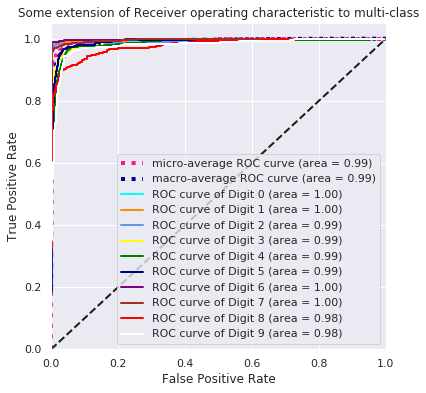

In [53]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'green', 'navy', 'purple', 'brown', 'red', 'white'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of Digit {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train,
#            alpha=.4, s=3**2, cmap='rainbow')
#plt.colorbar()
#plt.show()    
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()